In [ ]:
#Importing libraries needed
import os
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image
import time
import functools

In [ ]:
#Loading compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
content_path='/content/Technological_Institute_of_the_Philippines_Quezon_City.jpg'
style_path='/content/Sold Price_ PAUL GAUGUIN - TAHITIAN LANDSCAPE WITH A MOUNTAIN - June 2, 0119 12_00 AM PDT.jpg'

In [ ]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [ ]:
def load_img(path_to_img):
    max_dim= 512
    img= tf.io.read_file(path_to_img)
    img= tf.image.decode_image(img, channels=3)
    img= tf.image.convert_image_dtype(img, tf.float32)
    shape= tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img= tf.image.resize(img, new_shape)
    img= img[tf.newaxis, :]
    return img

In [ ]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
        plt.imshow(image)
    if title:
        plt.title(title)

In [ ]:
base_image=load_img(content_path)
style_image=load_img(style_path)

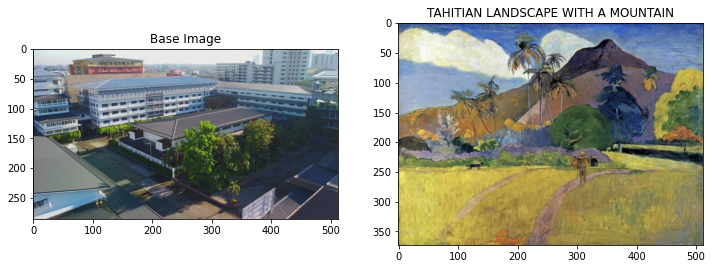

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False
plt.subplot(1, 2, 1)
imshow(base_image, 'Base Image')
plt.subplot(1, 2, 2)
imshow(style_image, 'TAHITIAN LANDSCAPE WITH A MOUNTAIN')

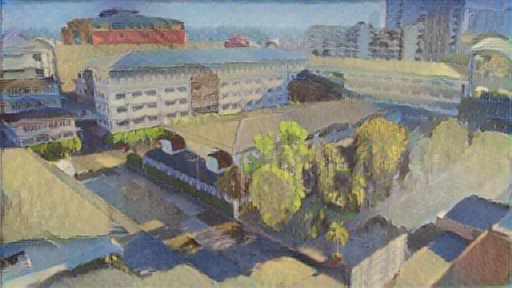

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(base_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [ ]:
x=tf.keras.applications.vgg19.preprocess_input(base_image*255)
x=tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def vgg_layers(layer_names):
    """ Creates a VGG model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on ImageNet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 373, 512, 64)
  min:  0.0
  max:  841.5154
  mean:  27.058853

block2_conv1
  shape:  (1, 186, 256, 128)
  min:  0.0
  max:  3114.2947
  mean:  135.62532

block3_conv1
  shape:  (1, 93, 128, 256)
  min:  0.0
  max:  7536.9263
  mean:  118.68109

block4_conv1
  shape:  (1, 46, 64, 512)
  min:  0.0
  max:  14059.68
  mean:  504.18866

block5_conv1
  shape:  (1, 23, 32, 512)
  min:  0.0
  max:  2473.7573
  mean:  40.808613



In [ ]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [ ]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(base_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ",name)
    print("    shape:",output.numpy().shape)
    print("    min:  ",output.numpy().min())
    print("    max:  ",output.numpy().max())
    print("    mean: ",output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape:", output.numpy().shape)
    print("    min:  ", output.numpy().min())
    print("    max:  ", output.numpy().max())
    print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape: (1, 64, 64)
    min:   0.052376866
    max:   15855.252
    mean:  505.8719

   block2_conv1
    shape: (1, 128, 128)
    min:   0.0
    max:   111882.47
    mean:  15729.45

   block3_conv1
    shape: (1, 256, 256)
    min:   0.0
    max:   383264.25
    mean:  16511.375

   block4_conv1
    shape: (1, 512, 512)
    min:   0.0
    max:   5120677.5
    mean:  235370.88

   block5_conv1
    shape: (1, 512, 512)
    min:   0.0
    max:   131512.83
    mean:  1749.0945

Contents:
   block5_conv2
    shape: (1, 17, 32, 512)
    min:   0.0
    max:   1082.0112
    mean:  16.220383


In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(base_image)['content']

In [ ]:
image= tf.Variable(base_image)

In [ ]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

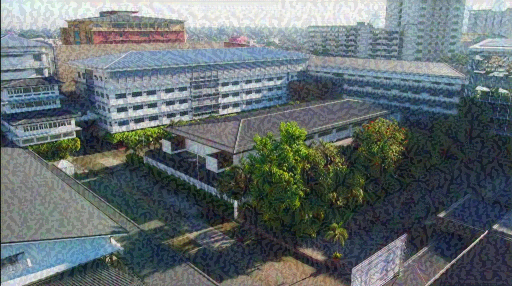

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

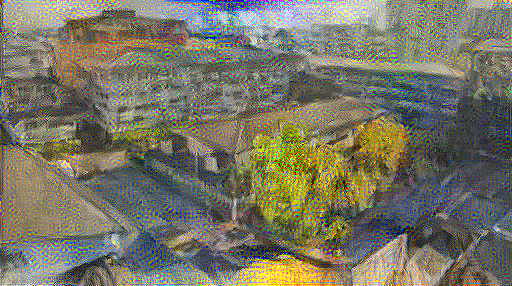

Train step: 10000
Total time: 538.7


In [ ]:
import time
start = time.time()
epochs = 100
steps_per_epoch = 100
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    
    return x_var, y_var

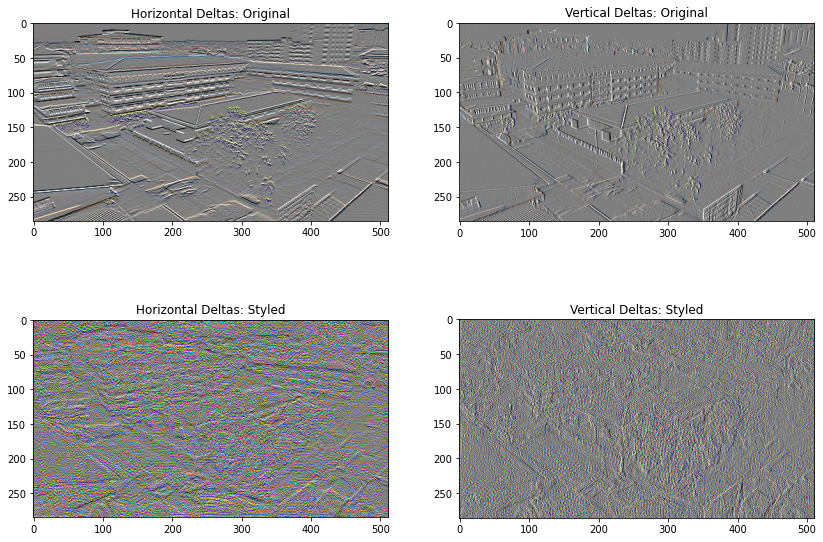

In [ ]:
x_deltas, y_deltas = high_pass_x_y(base_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

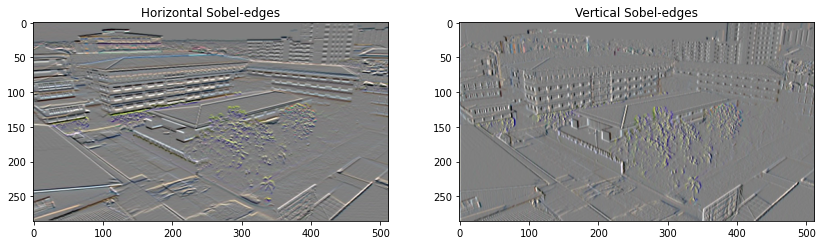

In [ ]:
plt.figure(figsize=(14, 10))
sobel = tf.image.sobel_edges(base_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [ ]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_loss(image).numpy()

151161.36

In [ ]:
tf.image.total_variation(image).numpy()

array([151161.36], dtype=float32)

In [ ]:
total_variation_weight=30

In [ ]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(base_image)

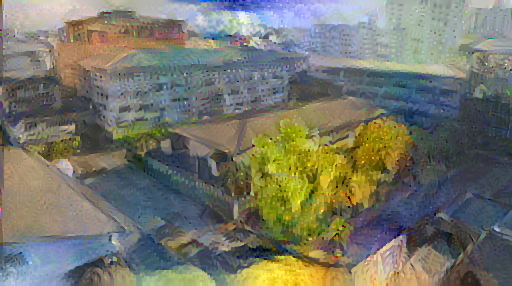

Train step: 10000
Total time: 545.4


In [ ]:
import time
start= time.time()
epochs= 100
steps_per_epoch= 100
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
end = time.time()
print("Total time: {:.1f}".format(end-start))